# Part 1 - Modeling the environment

## a) Describing the model

The game of blackjack has four phases which occur in a particular order. Game starts with a *start* phase where player is dealt two cards and dealer gets one card. *Start* is followed by *player* phase where player can either hit or stand. Once the player stands, the *dealer* phase starts where dealer can either hit or stand. After dealer stands, player goes bust or dealer goes bust, the game ends with *end* phase.

Game states are combinations of phase, player's cards and dealer's cards. For example the state could be following

* Game phase: *player*
* Player's cards: D4, C3, SA
* Dealer's cards: S9

In this exercise, an infinite deck is used, meaning that same card can be drawn infinitely many times. Because of that, the hands of player and dealer can be represented as a sum of cards' values instead of using the actual cards. This reduces the number of possible states significantly. There is also special card ace which can be have either value of 1 or 11. To represent this, a boolean attribute *usable ace* is added to both player and dealer. All aces are counted as 11 by default and using the ace means reducing it's value to 1. Using this approach, the same state could be repsented in following way

* Game phase: *player*
* Player's cards: 18
* Player's usable ace: True
* Dealer's cards: 9
* Dealer's usable ace: False

Even though there are now more attributes, the number of states has been reduced, making this a better model.

### Actions

For each state there must be at least one action, that the player can do. For states *start*, *dealer* and *end* the player's actions don't really matter, so there the player will do a *noop* - no operation. On the player's turn, the player's actions really have a meaning. There the player can choose to either *hit* or *stand*. If player chooses to *stand*, it's dealer's turn. With *hit*, the player is dealt a new random card, so the action is not deterministic. If the player goes bust, the next state will be *end*. Unlike in the example shown on lab and lecture, there are many *end* states for the different combinations of player's and dealer's hands. This is a difference in the model but it gives the same results than what was shown.

### Successor states

After the start state, the cards are dealt. Successor states are all the possible ways to deal two cards for the player and one for the dealer (reduced to this model). After the player hits, a new card is dealt. If player doesn't go bust, a new *player* state is reached. Usable aces are used automatically, if the player would go bust otherwise. If player goes bust, *end* state is reached. If player decides to stand, the state becomes *dealer*.

### Transition probabilities

Another consequence of having an infinite deck is that the probability of drawing one card doesn't change over time. The probability of getting a card with a value of 10 is always $\frac{4}{13}$ (10, Jack, Queen, King) while the probability of getting any other value is always $\frac{1}{13}$ for each (Ace, 2, 3, 4, 5, 6, 7, 8, 9).

### Rewards

The reward the agent gets is $1$ (win), $-1$ (lose) or $0$ (draw or any transition that does not end in a terminal state).

## b) Implementing the model
Our model has 1679 states, which can be seen below. There is one start state, 280 states when it's player's turn, 868 states when it's dealer's turn and 530 terminal states.

We set the discount factor to $1$ since this is an episodic task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from itertools import islice

# An abstract class representing a Markov Decision Process (MDP).
class MDP:
    def __init__(self):
        self.computeStates()

    # discount factor
    discountFactor = 1

    # Return the start state.
    def startState(self): raise NotImplementedError("Override me")

    # Return set of actions possible from |state|.
    def actions(self, state): raise NotImplementedError("Override me")

    # Return a list of (newState, prob, reward) tuples corresponding to edges
    # coming out of |state|.
    # Mapping to notation from class:
    #   state = s, action = a, newState = s', reward = r, prob = p(s', r | s, a)
    # If state is a terminal state, return the empty list.
    def succAndProbReward(self, state, action): raise NotImplementedError("Override me")

    # Compute set of states reachable from startState.  Helper function
    # to know which states to compute values and policies for.
    # This function sets |self.states| to be the set of all states.
    def computeStates(self):
        self.states = set()
        queue = []
        self.states.add(self.startState())
        queue.append(self.startState())
        while len(queue) > 0:
            state = queue.pop()
            for action in self.actions(state):
                for newState, prob, reward in self.succAndProbReward(state, action):
                    if newState not in self.states:
                        self.states.add(newState)
                        queue.append(newState)
                        #print(newState)
        print("%d reachable states" % len(self.states))
        print("---> %d start state" % len([x for x in self.states if x[4]=="start"]))
        print("---> %d player states" % len([x for x in self.states if x[4]=="player"]))
        print("---> %d dealer states" % len([x for x in self.states if x[4]=="dealer"]))
        print("---> %d terminal states" % len([x for x in self.states if x[4]=="end"]))
        
class BlackjackMDP(MDP):
    
    # the discount factor for future rewards
    discountFactor = 1 # TODO: set this to the correct value
    
    # Return the start state.
    def startState(self):
        return (0, False, 0, False, "start")

    # Return set of actions possible from |state|.
    def actions(self, state):
        # TODO: you may need to change this depending on your model
        #       not all actions may always be possible
        if state[4] == "player":
            return ["Hit", "Stand"]
        else:
            return ["Noop"]

    # Return a list of (newState, prob, reward) tuples corresponding to edges
    # coming out of |state|.
    # Mapping to notation from class:
    #   state = s, action = a, newState = s', reward = r, prob = p(s', r | s, a)
    # If state is a terminal state, return the empty list.
    def succAndProbReward(self, state, action):
        # TODO: implement this
        return_list = []
        if state[4] == "player" and action == "Hit":
            for card in range (2,12):
                usable_ace = state[1]
                pr_card = 4 / 52
                if card == 10:
                    pr_card = 16 / 52
                if card == 11:
                    if state[1] == False:
                        usable_ace = True
                    else:
                        card-=10
                if state[0]+card>21 and usable_ace==False:
                    new_state=(state[0]+card,False,state[2],state[3],"end")
                    return_list.append((new_state, pr_card, -1))
                elif state[0]+card>21 and usable_ace==True:
                    if state[0]+card-10>21:
                        new_state=(state[0]+card,False,state[2],state[3],"end")
                        return_list.append((new_state, pr_card, -1))
                    else:
                        new_state=(state[0]+card-10,False,state[2],state[3],"player")
                        return_list.append((new_state, pr_card, 0))
                elif state[0]+card<=21:
                    new_state=(state[0]+card,usable_ace,state[2],state[3],"player")
                    return_list.append((new_state, pr_card, 0))
        elif state[4] == "player" and action == "Stand":
            new_state = (state[0], state[1], state[2], state[3], "dealer")
            return_list.append((new_state, 1, 0))
        elif state[4] == "dealer":
            usable_ace = state[3]
            if state[2]>=17:
                x = 0
                if state[0]>state[2]:
                    x=1
                elif state[0]<state[2]:
                    x=-1
                new_state = (state[0], state[1], state[2], state[3], "end")
                return_list.append((new_state, 1, x))
                return return_list
            for card in range (2,12):
                pr_card = 4 / 52
                if card == 10:
                    pr_card = 16 / 52
                if card == 11:
                    if state[3] == False:
                        usable_ace = True
                    else:
                        card-=10
                if state[2]+card>21 and usable_ace==False:
                    new_state=(state[0],state[1],state[2]+card,usable_ace,"end")
                    return_list.append((new_state, pr_card, 1))
                elif state[2]+card>21 and usable_ace==True:
                    if state[2]+card-10>21:
                        new_state=(state[0],state[1],state[2]+card,usable_ace,"end")
                        return_list.append((new_state, pr_card, 1))
                    else:
                        new_state=(state[0],state[1],state[2]+card-10,False,"dealer")
                        return_list.append((new_state, pr_card, 0))
                elif state[2]+card<=21:
                    new_state=(state[0],state[1],state[2]+card,usable_ace,"dealer")
                    return_list.append((new_state, pr_card, 0))
        elif state[4] == "start":
            for first in range(2, 12):
                usable_ace = False
                pr_first = 4/52
                if first == 10:
                    pr_first = 16/52
                if first == 11:
                    usable_ace = True
                for second in range(2, 12):
                    tmp_value = first + second
                    pr_second = 4/52
                    if second == 10:
                        pr_second = 16/52
                    if second == 11:
                        if usable_ace:
                            tmp_value -= 10
                        usable_ace = True

                    for third in range(2, 12):
                        pr_third = 4/52
                        if third == 10:
                            pr_third = 16/52
                        usable_ace_dealer = False
                        if third == 11:
                            usable_ace_dealer = True
                        probability = pr_first * pr_second * pr_third
                        new_state=(tmp_value,usable_ace,
                                   third,usable_ace_dealer,"player")
                        return_list.append((new_state, probability, 0))
        elif state[4] == "end":
            return []
        return return_list

    def simulateGame(self):
        state = self.startState()
        print(state)
        while state[4] != "end":
            possible_actions = self.actions(state)
            action=possible_actions[random.randint(0,len(possible_actions)-1)]
            print("Selected action:", action)
            possible_states = self.succAndProbReward(state, action)
            selected_random_state=possible_states[
                random.randint(0,len(possible_states)-1)]
            print(selected_random_state)
            state = selected_random_state[0]

mdp = BlackjackMDP()
for i in range(1,6):
    print("\nSimulate game #" + str(i))
    mdp.simulateGame()

1679 reachable states
---> 1 start state
---> 280 player states
---> 868 dealer states
---> 530 terminal states

Simulate game #1
(0, False, 0, False, 'start')
Selected action: Noop
((20, False, 2, False, 'player'), 0.007282658170232136, 0)
Selected action: Stand
((20, False, 2, False, 'dealer'), 1, 0)
Selected action: Noop
((20, False, 10, False, 'dealer'), 0.07692307692307693, 0)
Selected action: Noop
((20, False, 21, True, 'dealer'), 0.07692307692307693, 0)
Selected action: Noop
((20, False, 21, True, 'end'), 1, -1)

Simulate game #2
(0, False, 0, False, 'start')
Selected action: Noop
((10, False, 4, False, 'player'), 0.0004551661356395085, 0)
Selected action: Hit
((20, False, 4, False, 'player'), 0.3076923076923077, 0)
Selected action: Stand
((20, False, 4, False, 'dealer'), 1, 0)
Selected action: Noop
((20, False, 13, False, 'dealer'), 0.07692307692307693, 0)
Selected action: Noop
((20, False, 15, False, 'dealer'), 0.07692307692307693, 0)
Selected action: Noop
((20, False, 23, Fal

# Part 2 - Value Iteration
## a) Value iteration for MDP
Below is the code to compute the values of the states and find an optimal policy. After some testing we noticed that even with a very small value for theta (stopping criterion), the values converge in a moment. To save some space, only 20 of the state values and 20 of the policy rules are shown.

In [2]:
def V(mdp, v, state, action):
    possible_states = mdp.succAndProbReward(state, action)
    value = 0
    for pos_state in possible_states:
        value+=pos_state[1]*(pos_state[2]+mdp.discountFactor*v[pos_state[0]])
    
    return value

def valueIteration(mdp):
    large_negative_number = -1000000000
    v = {}
    for state in mdp.states:
        v[state] = 0
    
    # do actual value iteration
    theta = 0.0000000000000001
    delta = 2 * theta # any value, but it should be greater than theta

    while delta > theta:
        delta = 0
        for state in mdp.states:
            vv = v[state]
            maxi = large_negative_number
            for action in mdp.actions(state):
                maxi = max(maxi, V(mdp, v, state, action))
            v[state] = maxi
            delta = max(delta, abs(vv - v[state]))


    pi = {}

    # extract policy
    for state in mdp.states:
        maxi = large_negative_number
        best_action = None
        for action in mdp.actions(state):
            val = V(mdp, v, state, action)
            if val > maxi:
                maxi = val
                best_action = action
        pi[state] = best_action
            


    return (v, pi)

viter = valueIteration(mdp)

print("\nValue iteration")
for state, reward in list(islice(viter[0].items(), 20)):
    print(state, reward)

print("\nBest policy")
for state, action in list(islice(viter[1].items(), 20)):
    print(state, action)


Value iteration
(20, False, 22, False, 'end') 0
(15, True, 4, False, 'player') 0.05928537693117982
(6, False, 19, True, 'end') 0
(29, False, 8, False, 'end') 0
(5, False, 10, False, 'dealer') -0.5757818467646016
(15, True, 18, False, 'end') 0
(19, False, 20, True, 'dealer') -1
(9, False, 20, False, 'end') 0
(15, False, 2, False, 'dealer') -0.29278372720927737
(15, False, 6, False, 'player') -0.1536990158300045
(10, False, 18, True, 'end') 0
(4, False, 4, False, 'dealer') -0.21106310899491443
(10, False, 21, False, 'end') 0
(14, True, 17, True, 'dealer') -1
(21, True, 5, False, 'dealer') 0.8917538265952805
(12, True, 6, False, 'dealer') -0.1536990158300045
(8, False, 6, False, 'player') 0.11496015009622321
(4, False, 7, False, 'player') -0.08827920105846371
(12, False, 18, True, 'dealer') -1
(21, False, 2, False, 'player') 0.8820065154940401

Best policy
(20, False, 22, False, 'end') Noop
(15, True, 4, False, 'player') Hit
(6, False, 19, True, 'end') Noop
(29, False, 8, False, 'end') N

## b) Expected outcome
The expected outcome is approximately $-0.0466$ (this is the value of the start state), which means that the dealer will win more often. This was expected since the dealer always plays after the player. If the player goes bust, the dealer always wins, and if the player stands before he would have more than 21 points, the dealer still has a possibility to win. The player can always go bust while the dealer only when the player choose to stand before having more than 21 points.

In [3]:
print("\nStart state value:", viter[0][mdp.startState()])


Start state value: -0.04655597706669751


## c) Visualisation

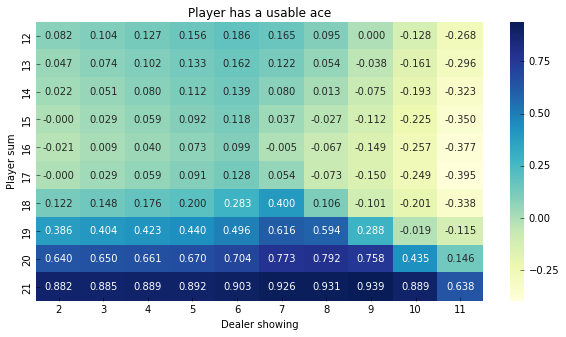

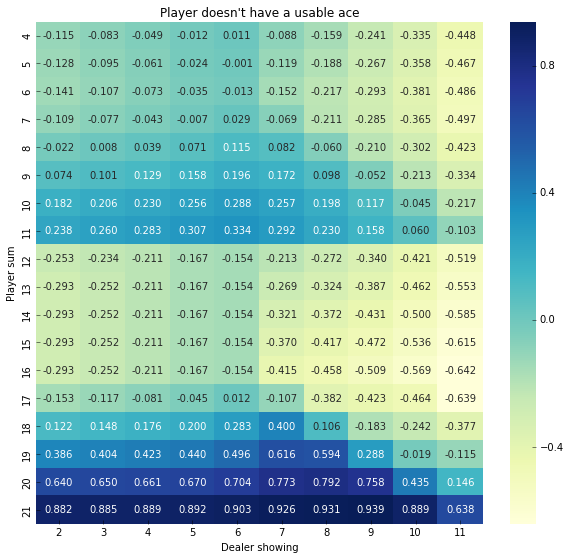

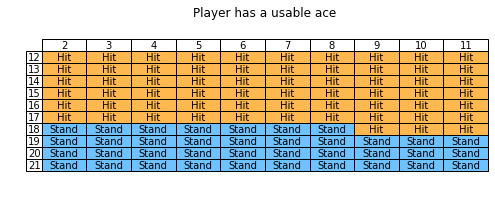

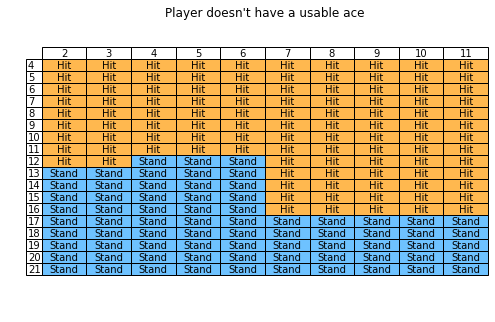

In [4]:
def report_value(mdp):
    playerTrue = []
    playerFalse = []
    for state, action in viter[0].items():
        if state[4] == "player":
            if state[1] == True:
                playerTrue.append([state[0], state[2], action])
            else:
                playerFalse.append([state[0], state[2], action])
                
    plot_value(playerTrue, "Player has a usable ace")
    plot_value(playerFalse, "Player doesn't have a usable ace")

def plot_value(orig_data, title):
    data = pd.DataFrame(orig_data)
    data = data.pivot(0, 1, 2)    
    
    plt.figure(figsize=(10,int(len(orig_data)/20)))
    ax = plt.axes()
    ax.set_title(title)
    hm = sns.heatmap(data, annot=True, fmt='.3f', ax=ax, cmap="YlGnBu")
    
    hm.set_ylabel("Player sum")
    hm.set_xlabel("Dealer showing")
    plt.show()
    
report_value(mdp)
#%%
def report_policy(mdp):
    playerTrue = []
    playerFalse = []
    for state, action in viter[1].items():
        if state[4] == "player":
            if state[1] == True:
                playerTrue.append([state[0], state[2], action])
            else:
                playerFalse.append([state[0], state[2], action])

    plot_policy(playerTrue, "Player has a usable ace",
                (8,3))
    plot_policy(playerFalse, "Player doesn't have a usable ace",
                (8,5))
        
def plot_policy(orig_data, title, figsize):
    orig_data.sort()
    min_player = orig_data[0][0]
    max_player = orig_data[len(orig_data)-1][0]
    min_dealer = orig_data[0][1]
    max_dealer = orig_data[len(orig_data)-1][1]
    
    column_count = max_dealer - min_dealer + 1
    row_count = max_player - min_player + 1
    
    cell_data = []
    
    #Initialize table
    for i in range (0, row_count):
        new_row = [[]] * column_count
        cell_data.append(new_row)
    
    #Set values of cells
    for state in orig_data:
        row = state[0] - min_player
        column = state[1] - min_dealer
        cell_data[row][column] = state[2]
        
        
    columns = np.arange(min_dealer, max_dealer + 1, 1)
    rows = np.arange(min_player, max_player + 1, 1)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    plt.title(title)
    ax.axis('off')
    ax.axis('tight')
    
    # Add colors
    colors=[[[0] for _ in range(len(cell_data[0]))] for _ in range(len(cell_data))]
    for y in range(len(colors)):
        for x in range(len(colors[0])):
            if (cell_data[y][x] == 'Hit'):
                colors[y][x] = '#FFB84F'
            else:
                colors[y][x] = '#6EC2FF'
    
    ax.table(cellText=cell_data,
              rowLabels=rows,
              colLabels=columns,
              loc='center',
              cellLoc='center',
              cellColours=colors)

    plt.show()


report_policy(mdp)

## d) Double down

## e) Using one deck

So far an infinite deck has been used, so the cards already dealt haven't affected the probabilites of drawing some card. For example, if the player has D4, C3, SA and the dealer has S9, the probability to draw a 3, 4, 9 or an ace is $\frac{3}{48}$ for each, the probability to draw a 2, 5, 6, 7 or 8 is $\frac{4}{48}$ for each, and the probability to draw a card with a value of 10 is $\frac{16}{48}$.

When using an infinite deck, it was enough to count the sums of the cards in both player's and dealer's hands. That is not possible anymore, because the probabilities of drawing new cards depend on the cards dealt earlier. So, the model must be changed to include the values of drawn cards. This will increase the number of states and make the model more complex. Some simplifications can still be used. Cards still have only a numeric value (no difference between suits) and cards 10, J, Q and K have the same value.